<a href="https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-i-auto-encoder?scriptVersionId=135302921" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Update June 2023

I'm now reading [_Generative Deep Learning_](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/)  [(Github)](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition) which covers AEs, VAEs, GANs and more.  I'm going to update my AE, VAE, and GAN notebooks and add to the list notebooks for the other generative models covered in the book - Autoregressive, Normalizing Flow, Energy-based, and Diffusion Models.

# Exploring Autoencoders, Variational Autoencoders and GANs for Images
# Part I - Auto-encoders

In the excellent book [_Hands on Machine Learning with Scikit-Learn, Keras, & Tensorflow_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/?_gl=1*rwm2lh*_ga*MTYxOTg4NzcxMy4xNjg2MDcwMDMx*_ga_092EL089CH*MTY4NzM5ODc4MC4yLjEuMTY4NzM5OTA0Ni4zLjAuMA..), Chapter 17 discusses autoencoders, variational autoencoders, and GANs.  Some of the problems at the end of the chapter do not have answers provided, so I decided to try my hand at them.  Question 10 asks the reader to develop a variational autoencoder with an image dataset and use it to generate images.  Question 11 extends this to generating new images using a GAN.

In Part I, I start by creating a standard, or frequentist, autoencoder.

In [Part II](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-ii-vae), I develop a Variational Autoencoder and show randomly generated images as well as images representing the average encoding for each class.

In [Part III](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-iii-gan), I will finish with a Generative Adversarial Network.

You can find code for the book [here](https://github.com/ageron/handson-ml2), and my Github repository with my answers to exercises [here](https://github.com/KirkDCO/HandsOnML_Exercises).


## What is an Autoencoder?

The simplest way to think about an autoencoder is as a neural network in which the inputs and the outputs are the same.  Between the input and output layers there may be only one or many layers, however, the sizes of the internal layers are typically smaller than the input and output layers, creating a bottleneck or choke point in the center.  Autoencoders typically have a symmetrical structure around the center bottleneck, noted as the "code" in the figure below.   Those layers leading into the code are referred to as the encoder and the layers leading out of the code referred to as the decoder.

<img src=attachment:fe57c81e-d7d8-45b7-a9b1-bb47463efb9d.png width="400">

The central layer is often referred to as an embedding layer in which the higher dimensional inputs are compressed to a smaller representation.  As a result of this compression, the internal layers must learn features that can best reproduce the inputs.  One form of auto-encoder, called a denoising auto-encoder, can be used to remove random noise from inputs.  This occurs due to the embedding representation learning the most salient features while effectively ignoring random noise.

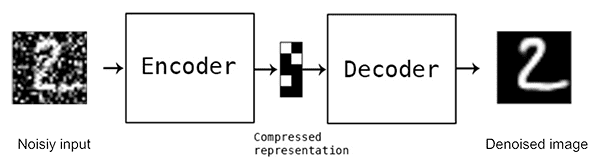

([Image source](https://blog.keras.io/building-autoencoders-in-keras.html))

Additional auto-encoder tutorials:

* [Building Auto-encoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Denoising autoencoders with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/)
* [Introduction to Auto-encoders](https://www.jeremyjordan.me/autoencoders/)

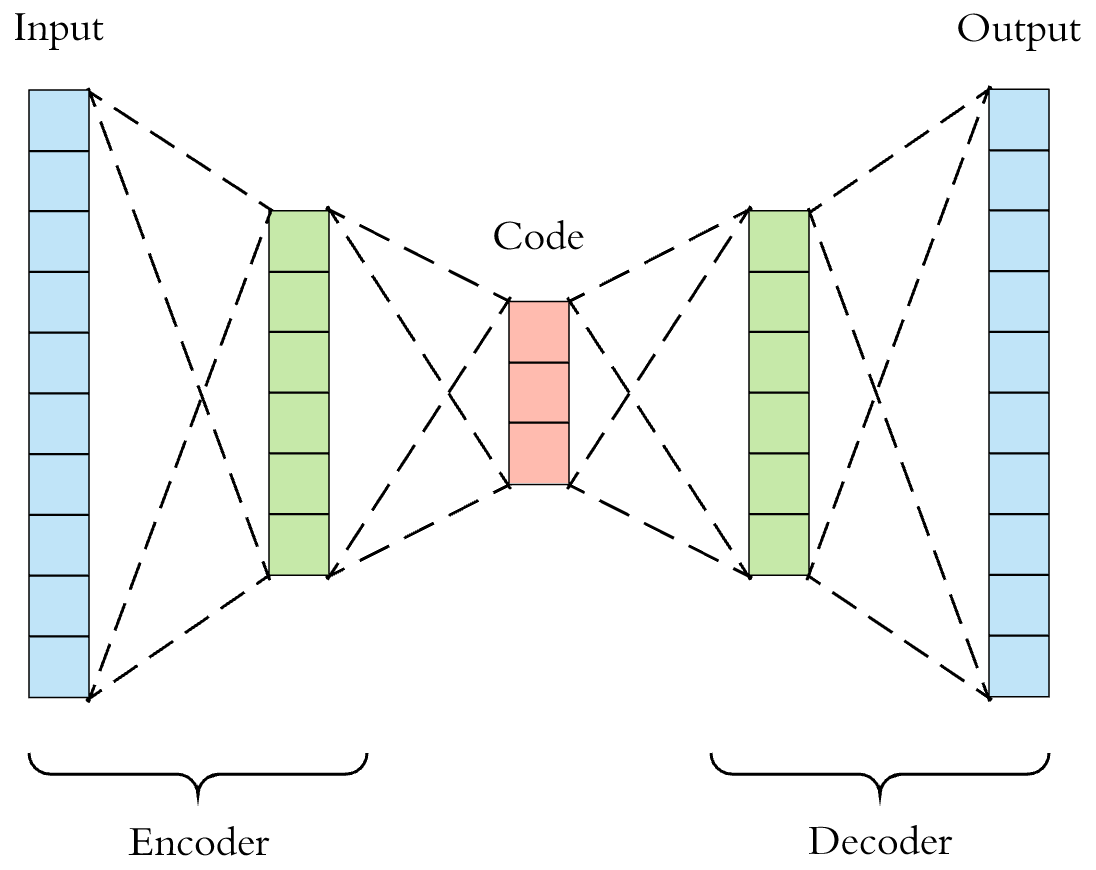

## Convolutional Autoencoder

For this notebook, I'm going to use a convolutional autoencoder.  This type of autoencoder takes images as inputs and consists of a series of convolutional layers for the encoder, leading to a central embedding layer.  The decoder consists of layers that reverse the convolutional layers and ultimately attempt to reproduce the original image as the output.


## Finding an image dataset
I wanted to find an interesting image dataset that was not too complex but also not too simple.  A dataset with RGB images would also be nice.  After much searching through the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview) and [Kaggle Datasets](https://www.kaggle.com/datasets), I found the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers) consisting of 13,838 JPEG 96 x 96 images of 14 different flowers.  (The dataset changed with the addtion of a new flower type while I was working on this notebook, so the latest version may not match the numbers of files I've quoted or that you see in outputs, below.)  I added the dataset directly to this notebook from its location on Kaggle.

First step is to import needed packages, set up global variables, and create generators for the flower images.

In [76]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 32 

IMG_WIDTH  = 96 
IMG_HEIGHT = 96 

ENCODING_SIZE = 8 

In [77]:
# create a flower generator with labels
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# keep the flower names for future reference
flower_names = flower_generator.class_names

# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'training'
)

# and a validation set generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'validation'
)

# autoencoders require the input matrix as both the input
# and the output
# provide input -> input for the autoencoder
# and, do scaling here
def replicate_inputs_to_outputs(images):
  return images/255, images/255

# create prefetch generators to speed things up a bit
training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

# create the final generators to be used in training the autoencoders
X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)


Found 15740 files belonging to 16 classes.
Found 15740 files belonging to 1 classes.
Using 12592 files for training.
Found 15740 files belonging to 1 classes.
Using 3148 files for validation.


## Examples from the Dataset

Taking a look at a few random images from the dataset we see that most of the images are nicely centered and often there is just one flower per image.  In some cases there are many flowers in a bouquet or bunch, or there are other background elements in image.  Dandelions are interesting as they may have the yellow flower or the white puffball seed stage.

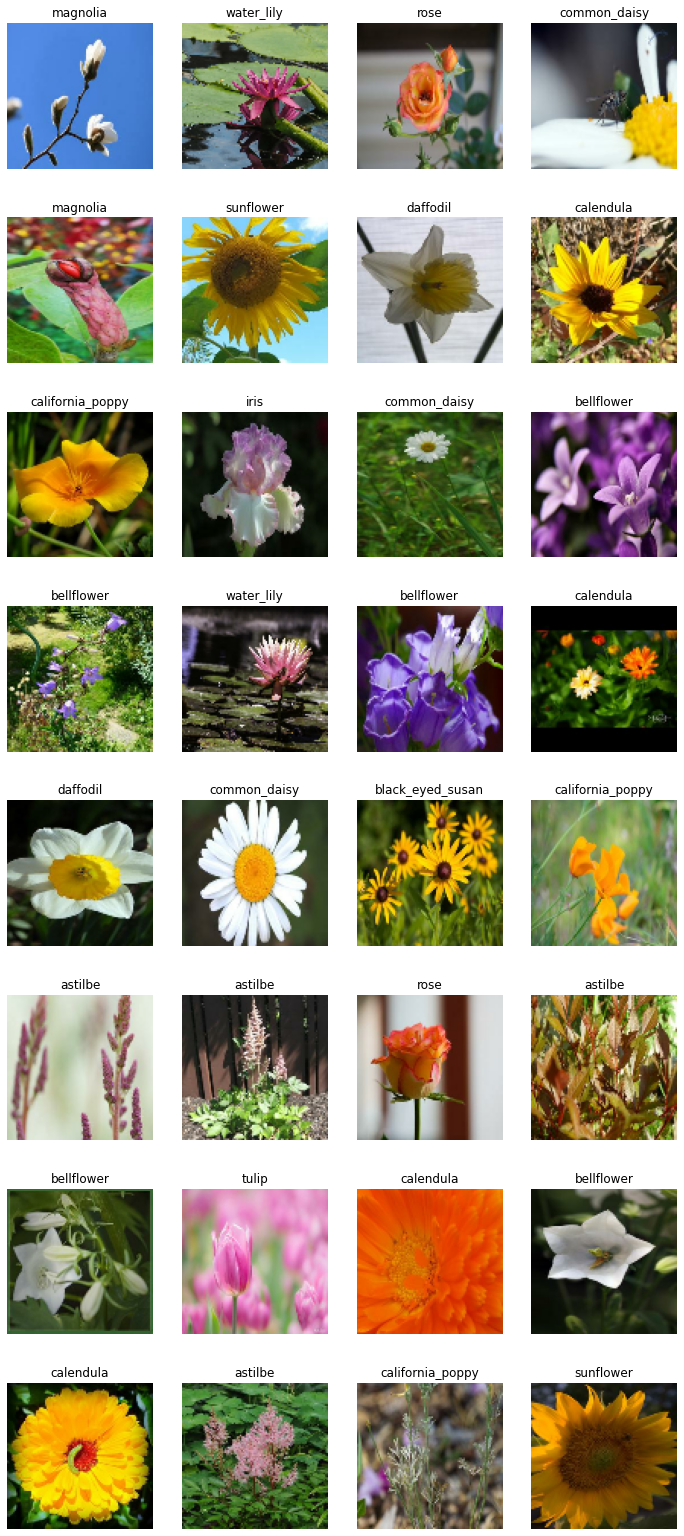

In [78]:
# visualize a few random flowers
plt.figure(figsize=(12, 28))

for images, labels in flower_generator.take(1):
  for i in range(len(images)):
      ax = plt.subplot(8, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(flower_names[labels[i]])
      plt.axis("off")

## Convolutional Autoencoder

I wanted to see how a convolutional autoencoder would perform with respect to image reconstruction.  I created a very simple 3 stage convolutional autoencoder consiting of 32 features for the original  96 x 96 RGB imgaes, followed by Max Pooling and 64 features for the 48 x 48 x 32 feature map, another Max Pooling step and finally 128 features for the 24 x 24 x 32 feature map.  I tried a number of different encoding layer sizes and found 1024 to produce better results than 512, and nearly as good as 2048.  

In [79]:
ENCODING_SIZE = 1024

# build a convolutional auto-encoder 
encoder = keras.models.Sequential([
            keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(64, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(128, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(ENCODING_SIZE)
])

encoder.summary()

decoder = keras.models.Sequential([
            keras.layers.Dense(128 * 24 * 24 , activation = "relu", input_shape = [ENCODING_SIZE]),
            keras.layers.Reshape([24, 24, 128]),
            keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, 
                                         padding = 'same', activation = 'sigmoid')
])

decoder.summary()

ae = keras.models.Sequential([encoder, decoder])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              7

In [ ]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

# compile and run
ae.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Nadam())
history = ae.fit(X_train, validation_data = X_valid,  epochs = 25, \
                 callbacks = [lr_scheduler, early_stopping_cb])

In [ ]:
# save model for future use
# handy for fast iteration and experiments
ae.save('trained_ae.h5')

In [80]:
# reload model
from tensorflow.keras.models import load_model
ae = load_model('trained_ae.h5')
encoder = ae.layers[0]

## Reconstructions

Looking at the reconstructions for a few random flowers from the validation set, they look quite good. Trying larger encodings (e.g., 2048) didn't produce substantially better results, and smaller encodings (512) produced somewhat degraded results.

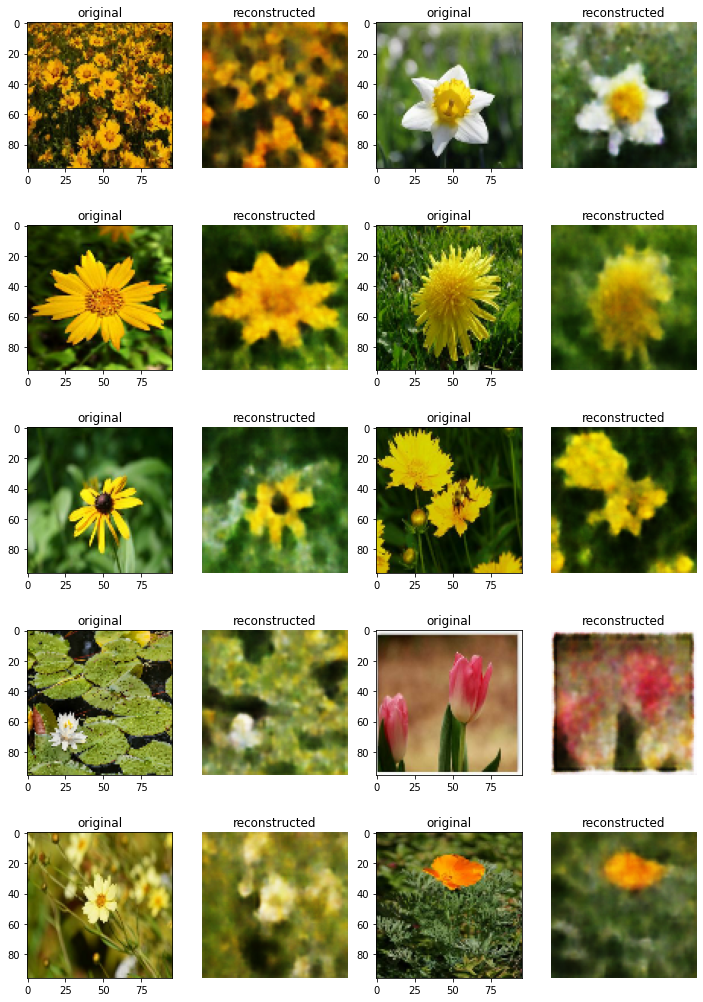

In [81]:
# visualize a few random flowers
# and their reconstructions
plt.figure(figsize=(12, 18))

for images, _ in X_valid.take(1):
  ae_images = ae.predict(images)
  for i in range(10):
    ax = plt.subplot(5, 4, (i * 2) + 1)
    plt.imshow(images[i])
    plt.title('original')

    ax = plt.subplot(5, 4, (i * 2) + 2)
    plt.imshow(ae_images[i])
    plt.title('reconstructed')
    plt.axis("off")

## Visualizing the Embeddings

The encoder has a 1024-dimensional embedding layer, and it would be interesting to see how the flower images are represented in this central layer.  To visualize the embeddings, a 1024-dimensional vector for each flower image will be generated with the encoder (without decoding it).  This will then be visualized using a UMAP projection with each point colored by the flower type.

In [82]:
# reset the generator to get the same order - is there a way to do this without recreating it?
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# get the embeddings and labels for the training set
embeddings = []
labels = []

for images, lbls in flower_generator:
    embeddings.append(encoder.predict(images))
    labels.append(lbls)
    
embeddings = np.concatenate(embeddings, axis = 0)
labels = np.concatenate(labels, axis = 0)

Found 15740 files belonging to 16 classes.


In [ ]:
from sklearn.preprocessing import StandardScaler
import umap

# scale the embeddings so that they are well-behaved for UMAP
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# use UMAP to project from 1024 dimensions down to 2 dimensions
# the cosine metric is used here, but euclidean works as well
umap_reducer = umap.UMAP(n_neighbors = 150, min_dist = 0.0, metric = 'cosine')
umap_embedding = umap_reducer.fit_transform(scaled_embeddings)

colors = plt.cm.tab20(np.linspace(0, 1, 16))

In [ ]:
# save the various embeddings and other variables
# again, handy for fast iteration and testing
import pickle as pkl

with open('embeddings_etc.pkl', 'wb') as fout:
    pkl.dump([embeddings, scaled_embeddings, umap_embedding, scaler, umap_reducer, colors, labels], fout)

In [83]:
# reload embeddings and transformations
import pickle as pkl

with open('embeddings_etc.pkl', 'rb') as fin:
    items = pkl.load(fin)
    
embeddings, scaled_embeddings, umap_embedding, scaler, umap_reducer, colors, labels = \
    items[0], items[1], items[2], items[3], items[4], items[5], items[6]

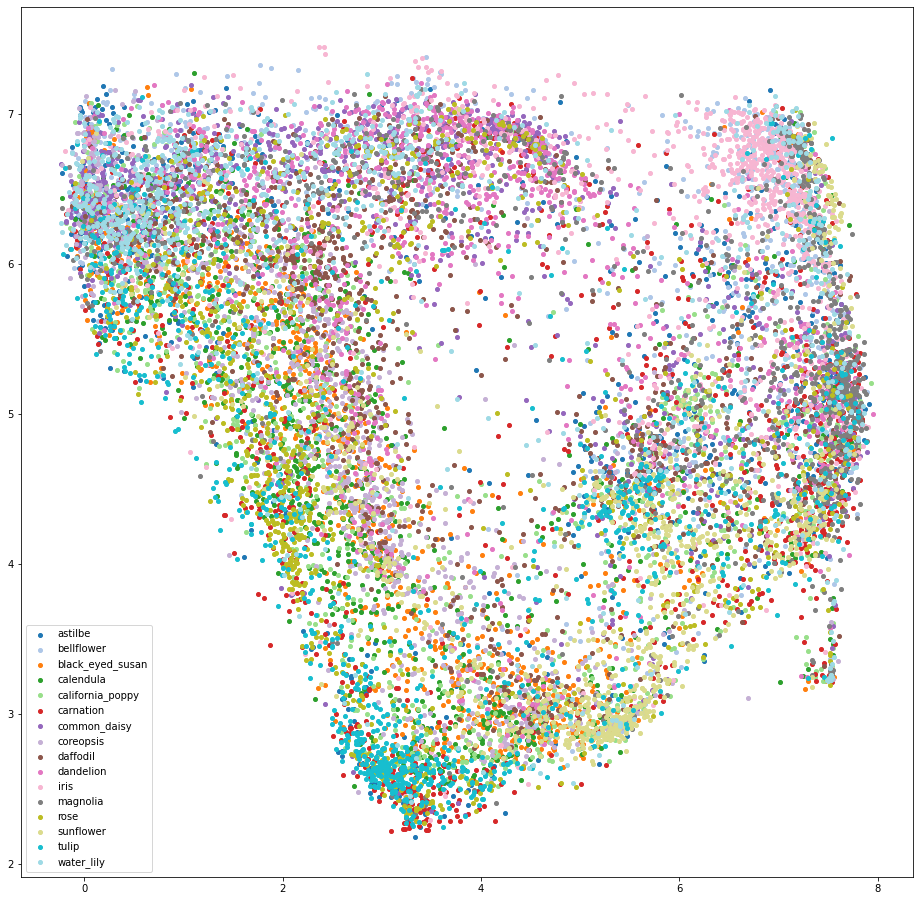

In [84]:
# visualize the 2D UMAP projection
fig, ax = plt.subplots(figsize = (16, 16))

for lbl in flower_names:
    name_idx = flower_names.index(lbl)
    flower_idx = [i for i, lbl in enumerate(labels) if lbl == name_idx]
    ax.scatter(umap_embedding[flower_idx, 0], umap_embedding[flower_idx, 1],
               c = colors[name_idx], label = flower_names[name_idx], s = 16)
    
ax.legend()
plt.show()

## Embeddings Interpretation

When project to 2 dimensions with UMAP, the embeddings show some clustering of flower types but thre is a significant degree of overlap in various regions of the embedding space.  Part of this could result from the projection from 1024-dimensions to 2-dimensions.  Various embedding dimensions were tried (e.g., 512, 256, 32, 2), and the results were similar, showing a noisy clustering, regardless of the size of the autoencoder's embedding.

The following figure illustrates the UMAP projected embeddings for each flower type, making it easier to interpret which flowers are mixed and which are more clustered.

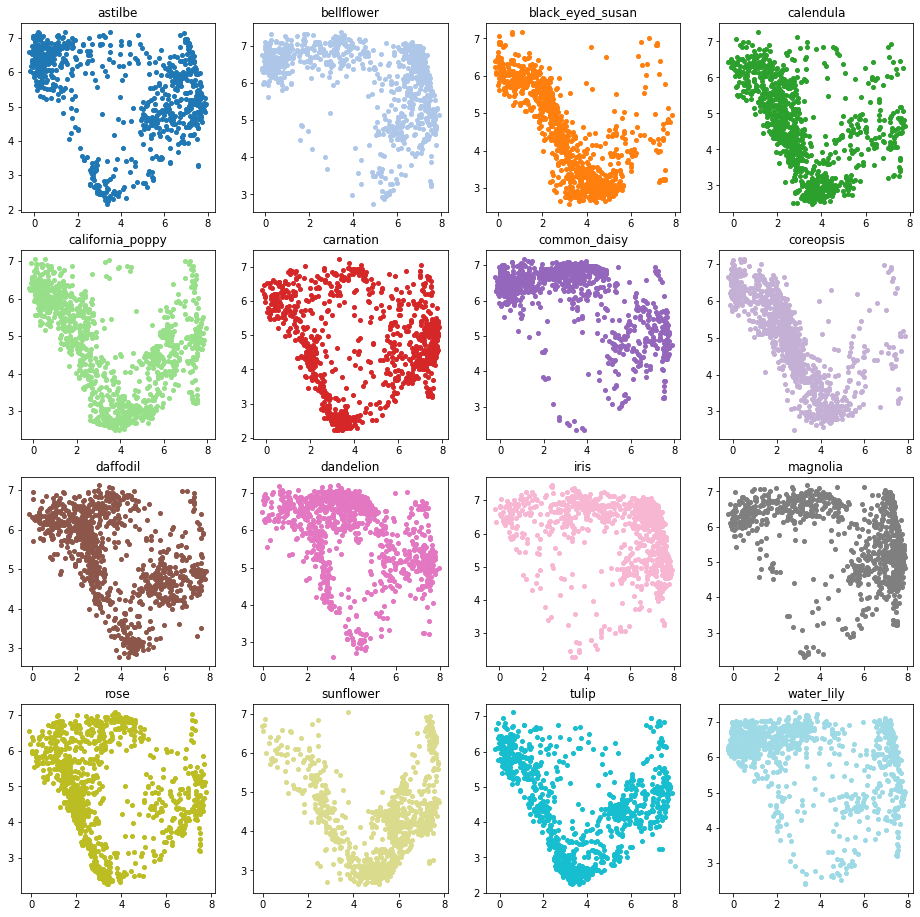

In [85]:
fig, ax = plt.subplots(figsize = (16, 16))

for flower in flower_names:
    name_idx = flower_names.index(flower)
    flower_idx = [i for i, lbl in enumerate(labels) if lbl == name_idx]
    ax = plt.subplot(4, 4, name_idx + 1)
    ax.scatter(umap_embedding[flower_idx, 0], umap_embedding[flower_idx, 1],
               c = colors[name_idx], label = flower_names[name_idx], s = 16)
    ax.title.set_text(flower)

## More Interpretation

Notice here that flowers with similar color and structure occupy similar regions of the embedding space.  Black eyed susan, calendula, and coreopsis all have radial petals from a central core of the flower, and all are yellow to orange in color.  These three are largely overlapping in the lower-left quadrant of the figure.  Additionally, California poppy, rose, and tulip occupy this region, and each of these is, or can be, similar in color to the others, while having a different structure.  Interestingly, sunflowers only occupy a portion of this region despite being similar in color and structure.

The following figure scans the UMAP projection space and identifies the 4 closest images to a given location the 2-dimensional space.  In some images, it is easy to see the structural and color similarities of the flowers.  There is also clearly a gradient related to the backgrounds of the images.  The upper-left contains images wtih dark backgrounds, such as water lillies on dark water, while the right side of the space has images with blue sky backgrounds.

Found 15740 files belonging to 16 classes.


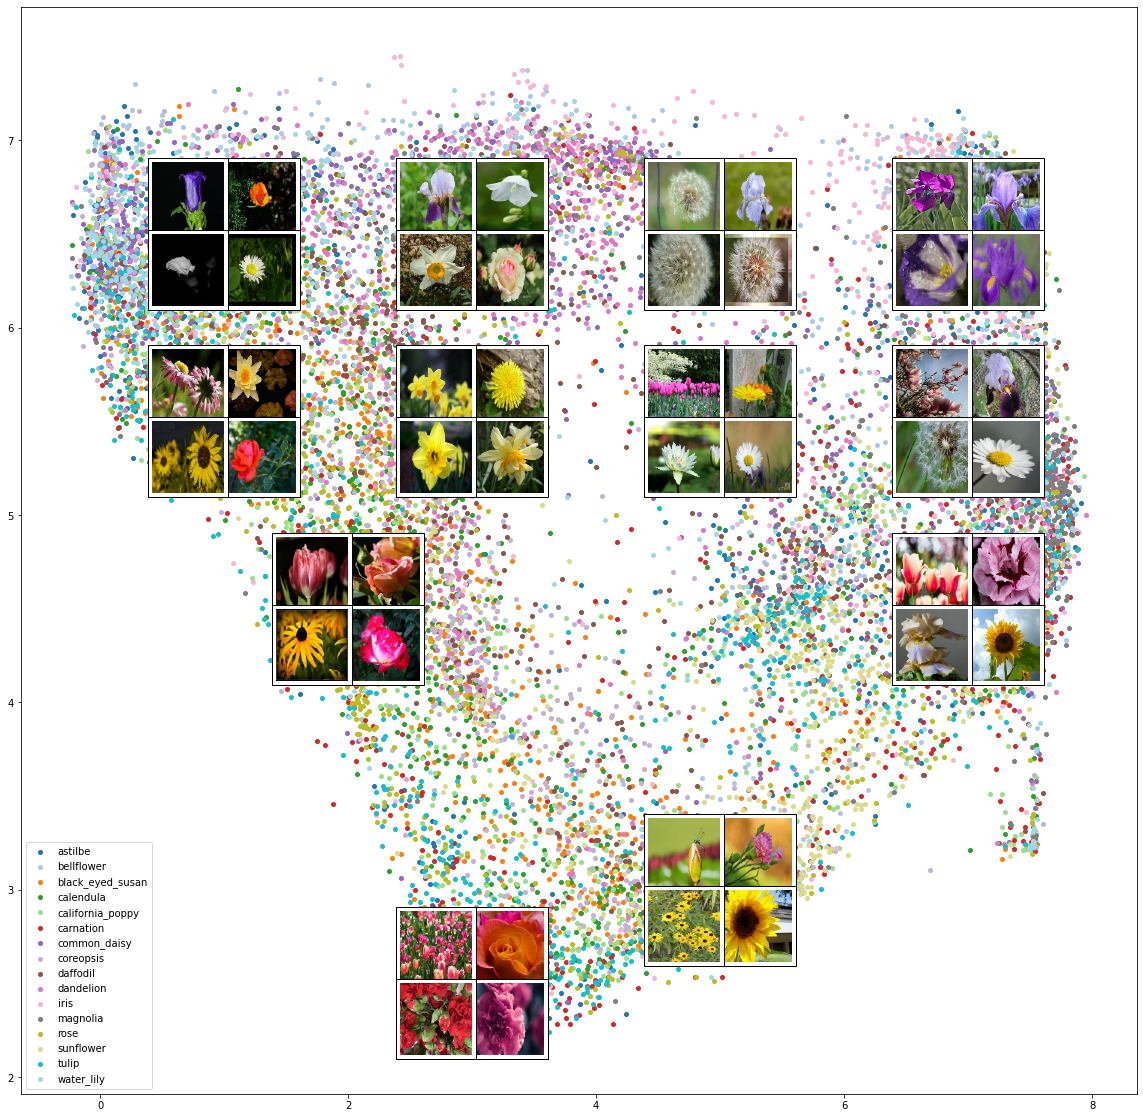

In [86]:
import scipy
from collections import defaultdict

# reset the generator to get the same order
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# find images closest to grid points on graph in umap space
grid_points = defaultdict(lambda: defaultdict(list))
reverse_grid_points = {}

for pt in [(1, 6.5), (3, 6.5), (5, 6.5), (7, 6.5),
           (1, 5.5), (3, 5.5), (5, 5.5), (7, 5.5),
           (2, 4.5), (7, 4.5),
           (5, 3),
           (3, 2.5)]:
    dists = scipy.spatial.distance.cdist(np.array([pt]), umap_embedding)
    dist_list = dists.tolist()[0]
    sorted_dist_list = sorted(dist_list)
    closest_idx = [dist_list.index(sorted_dist_list[i]) for i in range(4)]
    grid_points[pt]['closest_indexes'] = closest_idx
    reverse_grid_points.update({idx: pt for idx in closest_idx})

for batch, (images, _) in enumerate(flower_generator):
    for batch_index in range(BATCH_SIZE):
        idx = batch * BATCH_SIZE + batch_index
        if idx in reverse_grid_points:
            grid_points[reverse_grid_points[idx]]['images'].append(images[batch_index])
            
fig, ax = plt.subplots(figsize = (20, 20))

for lbl in flower_names:
    name_idx = flower_names.index(lbl)
    flower_idx = [i for i, lbl in enumerate(labels) if lbl == name_idx]
    ax.scatter(umap_embedding[flower_idx, 0], umap_embedding[flower_idx, 1],
               c = colors[name_idx], label = flower_names[name_idx], s = 16)
ax.legend()

from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)#The 

for pt in grid_points:
    images = grid_points[pt]['images']
    
    imagebox = OffsetImage(images[0].numpy().astype("uint8"), zoom = 0.75)
    ab = AnnotationBbox(imagebox, pt, frameon = True, box_alignment = (0, 0))
    ax.add_artist(ab)
    
    imagebox = OffsetImage(images[1].numpy().astype("uint8"), zoom = 0.75)
    ab = AnnotationBbox(imagebox, pt, frameon = True, box_alignment = (1, 0))
    ax.add_artist(ab)
    
    imagebox = OffsetImage(images[2].numpy().astype("uint8"), zoom = 0.75)
    ab = AnnotationBbox(imagebox, pt, frameon = True, box_alignment = (0, 1))
    ax.add_artist(ab)
    
    imagebox = OffsetImage(images[3].numpy().astype("uint8"), zoom = 0.75)
    ab = AnnotationBbox(imagebox, pt, frameon = True, box_alignment = (1, 1))
    ax.add_artist(ab)

plt.show()

## Dandelions

Dandelions are interesting since the images consist of both the yellow flower and white seed stages.  Looking at various regions of the dandelion embeddings reveals that the left side of the space contains primarily the yellow flower stage, while the top and right contain the white seed stage puffballs.  Interestingly, the lower-left appears to contain images that have both stages present.

Found 15740 files belonging to 16 classes.


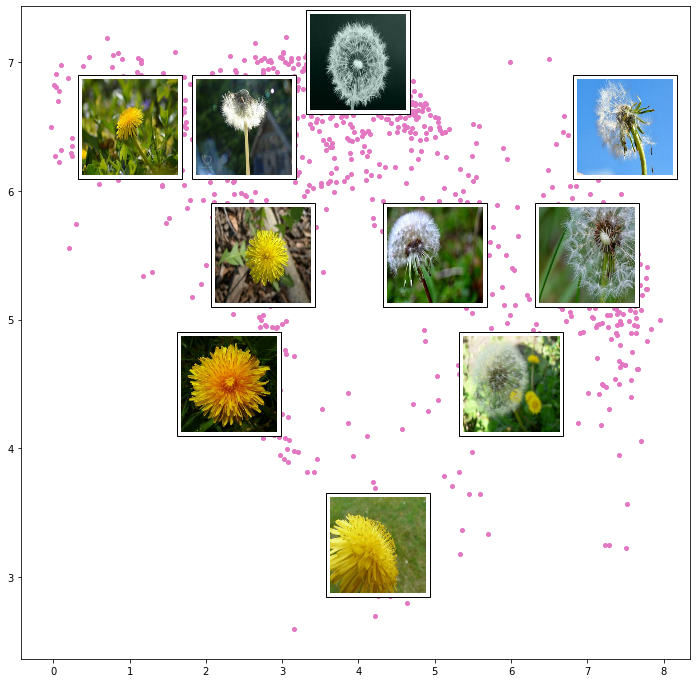

In [87]:
# reset the generator to get the same order
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "../input/flowers/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# find images closest to grid points on graph in umap space
grid_points = defaultdict(lambda: defaultdict(list))
reverse_grid_points = {}

flower = 'dandelion'
flower_name_idx = flower_names.index(flower)

target_indices = [i for i, l in enumerate(labels) if l == flower_name_idx]
target_umap_embedding = umap_embedding[target_indices]

for pt in [(4, 7),
           (1, 6.5), (2.5, 6.5), (7.5, 6.5), 
           (2.75, 5.5), (5, 5.5), (7, 5.5),
           (2.3, 4.5), (6, 4.5),
           (4.25, 3.25)]:
    dists = scipy.spatial.distance.cdist(np.array([pt]), target_umap_embedding)
    dist_list = dists.tolist()[0]
    closest_idx = dist_list.index(min(dist_list))
    closest_target_index = target_indices[closest_idx] 
    grid_points[pt]['closest_index'] = closest_target_index
    reverse_grid_points.update({closest_target_index: pt})

for batch, (images, lbls) in enumerate(flower_generator):
    for batch_index in range(len(images)):
        idx = batch * BATCH_SIZE + batch_index
        if idx in reverse_grid_points:
            grid_points[reverse_grid_points[idx]]['images'] = images[batch_index]

fig, ax = plt.subplots(figsize = (12, 12))

flower_idx = [i for i, lbl in enumerate(labels) if lbl == flower_name_idx]
ax.scatter(umap_embedding[flower_idx, 0], umap_embedding[flower_idx, 1],
           c = colors[flower_name_idx], label = flower, s = 16)

from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

for pt in grid_points:
    images = grid_points[pt]['images']
    
    imagebox = OffsetImage(images.numpy().astype("uint8"))
    ab = AnnotationBbox(imagebox, pt, frameon = True)
    ax.add_artist(ab)

plt.show()

## Morphing from One Image to Another

The dandelions offer an opportunity to scan the embedding space between the flower and seed stages, and to morph an image from one to the other.  An image of each type was selected and used as the starting and ending points.  The difference between their respective embeddings was computed and then a series of regularly spaced steps between the two was taken, adding that value to the starting image.  As this standard auto-encoder is not typically considered a generative model, the intermediate stages between the two images do not correspond to any actual image.  The "reconstructions" of these intermediate points are all of similar quality to the actual image reconstructions, showing that the model does have the ability to generate new images, although these are really just combinations of the starting and ending images, with different levels of each.

In [88]:
orig_images =[grid_points[(2.3, 4.5)]['images'] / 255, 
              grid_points[(4, 7)]['images'] / 255]

start_image_embedding, end_image_embedding = encoder.predict(np.array(orig_images))
step_size = (end_image_embedding - start_image_embedding) / 9

embedding_steps = [start_image_embedding + step_size * i for i in range(10)]

decoder = ae.layers[1]
reconstructions = decoder.predict(np.array(embedding_steps))

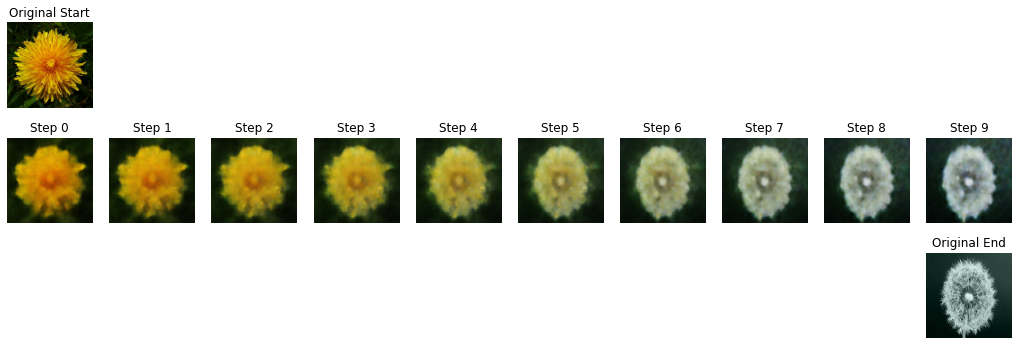

In [89]:
plt.figure(figsize=(18, 6))

ax = plt.subplot(3, 10, 1)
plt.imshow(orig_images[0])
plt.title('Original Start')
plt.axis('off')

for i, recon in enumerate(reconstructions):
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(recon)
    plt.axis('off')
    plt.title(f'Step {i}')
    
plt.subplot(3, 10, 30)
plt.imshow(orig_images[1])
plt.axis('off')
plt.title('Original End')

plt.show()

## Conclusions

Creating a convolutional autoencoder was quite simple.  The most time consuming part was experimentation to deterimine the overall network atchitecture - how many convolutional layers, how many features per layer, size of encoding layer.  Each new architecture change required training time.  Comparison of the results was much faster and consisted of simple visual comparison rather than a computational metric approach.  

Flower types show some degree of clustering within the embedding space, but there is considerable overlap between different flower types.  This is likely due to similar structure and color of the flowers themselves, as well as similarities in background details.

Finally, this frequentist autoencoder can indeed be used to generate images from embedding locations not corresponding to any existing image, and the generated reconstructions are of reasonably good quality compared to actual image reconstructions.  They are, however, simply combinations of the starting and ending image with each represented to a different degree.

## Next Up

I want to explore the frequentist auto-encoder a bit more and will follow up with another dataset of different images.  The link will be posted here when I have completed that work.

In [Part II](https://www.kaggle.com/code/kirkdco/auto-encoder-vae-gan-part-ii-vae), I will use this flowers dataset to develop a Variational Autoencoder and make an attempt at generated new flower images.